# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

2.9445889177835567 0.19573190500807597
2.9485897179435887 0.19180693453838563
2.9525905181036207 0.18787889393390508
2.9565913182636527 0.18394784606834713
2.9605921184236847 0.18001385386355995
2.9645929185837168 0.17607698028851995
2.9685937187437488 0.17213728835832381
2.972594518903781 0.1681948411331799
2.976595319063813 0.1642497017173989
2.980596119223845 0.16030193325838366
2.984596919383877 0.15635159894561856
2.988597719543909 0.152398762009658
2.992598519703941 0.1484434857211143
2.996599319863973 0.144485833389645
3.000600120024005 0.14052586836293945
3.004600920184037 0.13656365402570494
3.008601720344069 0.13259925379865206
3.012602520504101 0.12863273113747958
3.016603320664133 0.12466414953185873
3.020604120824165 0.12069357250441701
3.024604920984197 0.11672106360972143
3.028605721144229 0.11274668643326116
3.032606521304261 0.10877050459042982
3.036607321464293 0.1047925817255072
3.040608121624325 0.10081298151064057
3.044608921784357 0.09683176764482546
3.04860972194

5.6571314262852574 -0.5859516063964241
5.6611322264452895 -0.5827048929708625
5.6651330266053215 -0.5794488525490239
5.6691338267653535 -0.5761835372483304
5.6731346269253855 -0.5729089993346616
5.6771354270854175 -0.5696252912215173
5.6811362272454495 -0.5663324654691794
5.6851370274054815 -0.56303057478387
5.689137827565514 -0.559719672016908
5.693138627725545 -0.5563998101638639
5.697139427885577 -0.5530710423637083
5.701140228045609 -0.5497334218979664
5.705141028205641 -0.5463870021898615
5.709141828365673 -0.5430318368034609
5.713142628525705 -0.5396679794428189
5.717143428685737 -0.5362954839511163
5.721144228845769 -0.5329144043097995
5.725145029005801 -0.5295247946377162
5.729145829165833 -0.5261267091902485
5.733146629325865 -0.5227202023584454
5.737147429485897 -0.5193053286681517
5.741148229645929 -0.5158821427791352
5.745149029805961 -0.5124506994842121
5.749149829965993 -0.5090110537083696
5.753150630126025 -0.5055632605078871
5.757151430286057 -0.5021073750694546
5.76115

0.9115847115121654
8.281656331266253 0.9099326422045523
8.285657131426285 0.9082660081687749
8.289657931586317 0.9065848360816119
8.29365873174635 0.9048891528525435
8.297659531906382 0.9031789856233208
8.301660332066414 0.9014543617675312
8.305661132226446 0.8997153088901606
8.309661932386478 0.8979618548271512
8.31366273254651 0.8961940276449558
8.317663532706542 0.8944118556400894
8.321664332866574 0.8926153673386752
8.325665133026606 0.8908045914959887
8.329665933186638 0.888979557095997
8.33366673334667 0.8871402933508954
8.337667533506702 0.8852868297006393
8.341668333666734 0.8834191958124734
8.345669133826766 0.8815374215804563
8.349669933986798 0.8796415371249827
8.35367073414683 0.8777315727923005
8.357671534306862 0.8758075591540257
8.361672334466894 0.8738695270066531
8.365673134626926 0.8719175073710624
8.369673934786958 0.8699515314920232
8.37367473494699 0.8679716308376932
8.377675535107022 0.865977837099116
8.381676335267054 0.8639701821897129
8.385677135427086 0.861948

-0.998718324577917
11.050210042008402 -0.9985078384069288
11.054210842168434 -0.998281369739477
11.058211642328466 -0.9980389222005049
11.062212442488498 -0.9977804996707205
11.06621324264853 -0.9975061062865328
11.070214042808562 -0.9972157464399869
11.074214842968594 -0.9969094247786929
11.078215643128626 -0.9965871462057521
11.082216443288658 -0.9962489158796777
11.08621724344869 -0.9958947392143133
11.090218043608722 -0.9955246218787451
11.094218843768754 -0.9951385697972123
11.098219643928786 -0.9947365891490113
11.102220444088818 -0.9943186863683974
11.10622124424885 -0.9938848681444814
11.110222044408882 -0.9934351414211231
11.114222844568914 -0.9929695133968194
11.118223644728946 -0.9924879915245899
11.122224444888978 -0.9919905835118566
11.12622524504901 -0.9914772973203217
11.130226045209042 -0.9909481411658394
11.134226845369074 -0.9904031235182842
11.138227645529106 -0.9898422531014162
11.142228445689138 -0.9892655388927406
11.14622924584917 -0.9886729901233647
11.150230046

14.174834966993398 0.9992906437949224
14.17883576715343 0.9991319800754246
14.182836567313462 0.9989573238692141
14.186837367473494 0.9987666779719043
14.190838167633526 0.9985600454350463
14.194838967793558 0.9983374295660788
14.19883976795359 0.9980988339282764
14.202840568113622 0.9978442623406915
14.206841368273654 0.9975737188780939
14.210842168433686 0.9972872078709051
14.214842968593718 0.9969847339051294
14.21884376875375 0.9966663018222803
14.222844568913782 0.9963319167193029
14.226845369073814 0.9959815839484922
14.230846169233846 0.995615309117408
14.234846969393878 0.9952330980887848
14.23884776955391 0.9948349569804374
14.242848569713942 0.9944208921651643
14.246849369873974 0.9939909102706442
14.250850170034006 0.9935450181793312
14.254850970194038 0.9930832230283435
14.25885177035407 0.9926055322093503
14.262852570514102 0.9921119533684526
14.266853370674134 0.9916024944060611
14.270854170834166 0.9910771634767699
14.274854970994198 0.9905359689892257
14.27885577115423 

-0.7334224009118514
16.535307061412283 -0.7361361606013466
16.539307861572315 -0.7388381374153037
16.543308661732347 -0.7415282881048536
16.54730946189238 -0.7442065696104206
16.55131026205241 -0.7468729390624116
16.555311062212443 -0.7495273537819025
16.559311862372475 -0.7521697712813211
16.563312662532507 -0.7548001492651272
16.56731346269254 -0.7574184456304897
16.57131426285257 -0.7600246184679607
16.575315063012603 -0.7626186260621458
16.579315863172635 -0.7652004268923723
16.583316663332667 -0.7677699796333536
16.5873174634927 -0.7703272431558505
16.59131826365273 -0.77287217652733
16.595319063812763 -0.7754047390126199
16.599319863972795 -0.7779248900745612
16.603320664132827 -0.7804325893746572
16.60732146429286 -0.7829277967737183
16.61132226445289 -0.7854104723325052
16.615323064612923 -0.7878805763123683
16.619323864772955 -0.7903380691758831
16.623324664932987 -0.7927829115874836
16.62732546509302 -0.7952150644140917
16.63132626525305 -0.7976344887257438
16.635327065413083

0.7921946591553569
19.767953590718143 0.7946298748039452
19.771954390878175 0.7970523713043449
19.775955191038207 0.7994621098811553
19.77995599119824 0.8018590519631835
19.78395679135827 0.8042431591840624
19.787957591518303 0.8066143933828646
19.791958391678335 0.8089727166047128
19.795959191838367 0.8113180911013882
19.7999599919984 0.8136504793319341
19.80396079215843 0.8159698439632568
19.807961592318463 0.8182761478707231
19.811962392478495 0.8205693541387553
19.815963192638527 0.822849426061421
19.81996399279856 0.8251163271430211
19.82396479295859 0.8273700210986744
19.827965593118623 0.8296104718548978
19.831966393278655 0.8318376435501836
19.835967193438687 0.8340515005355742
19.83996799359872 0.8362520073752322
19.84396879375875 0.8384391288470077
19.847969593918783 0.8406128299430019
19.851970394078815 0.842773075870128
19.855971194238847 0.8449198320506673
19.85997199439888 0.8470530641228237
19.86397279455891 0.8491727379412726
19.867973594718944 0.8512788195777083
19.871

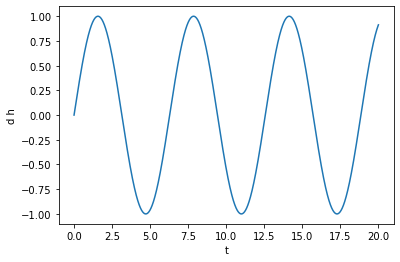

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

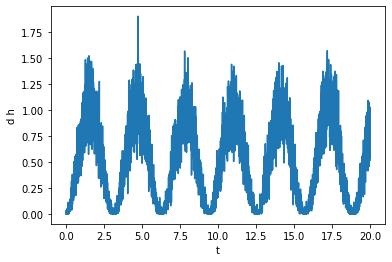

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

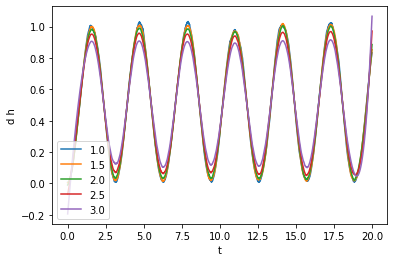

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

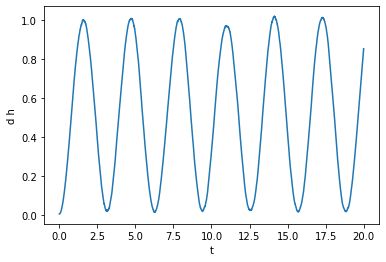

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1795


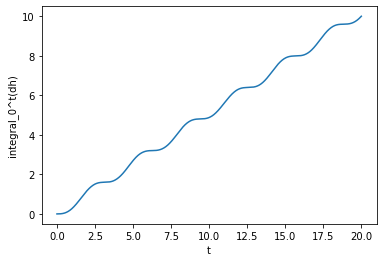

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

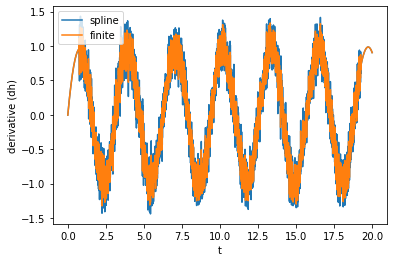

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

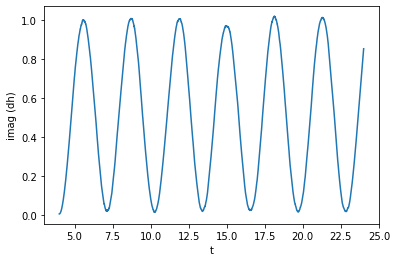

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

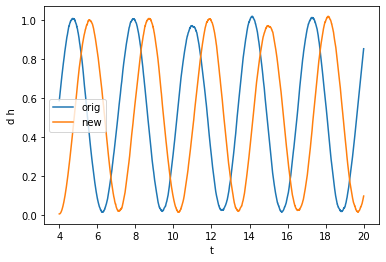

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

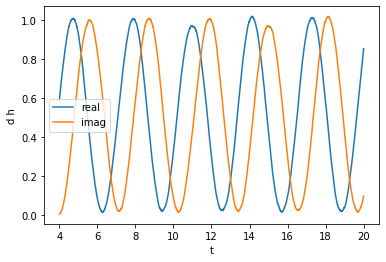

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

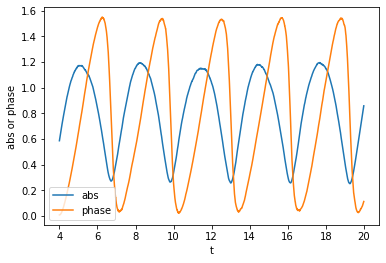

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

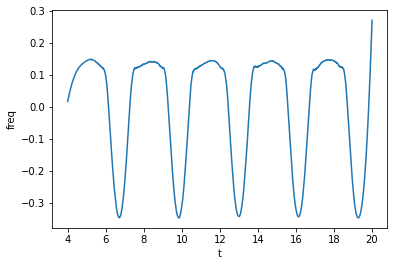

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

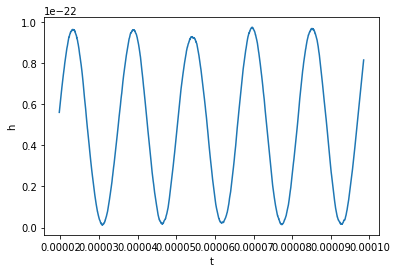

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

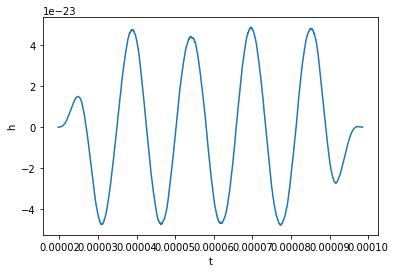

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

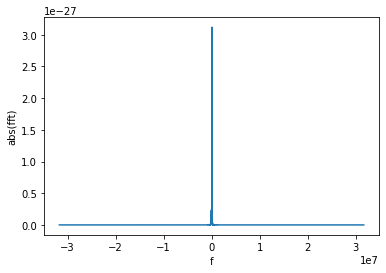

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

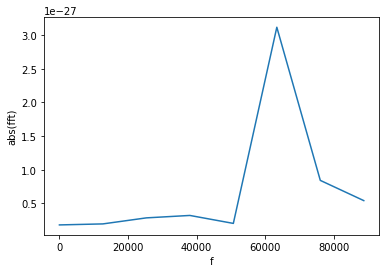

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64213.13


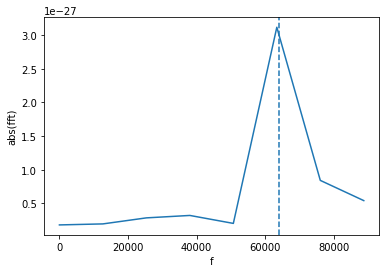

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.118e-27
Maximum with mask 8.425e-28
Length with mask 8
Length after having removed the masked points 7
